<a href="https://colab.research.google.com/github/Palaeoprot/IPA/blob/main/Polymer_IPA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation Model for Peptide Decay and Racemization

## Overview

This simulation model is designed to study the decay and racemization of a peptide polymer over time. The model uses a simple model with only three amino acids A, P, and I and tracks the breakdown of peptide bonds, the formation of free amino acids, and the racemization (conversion between L and D forms) of these amino acids. Multiple simulations are run to average the results, providing smoother and more reliable data.

## The Players I P A

- **I and i - Internal Racemization**: Simulates Asx [and Ser and Glx?] - is able to undergo racemization in chain
- **P and p - Polar Residue**: Simulates Tyr, Thr, Ser, Cys,  More accessible to water for hydrolysis.
- **A and a Apolar residues**: Simules Val, Phe, Ile, Leu  [and Ala] residues that are harder to racemize
- **Special cases**: Serie decays to racemiice alanaine.  Gln and Glu from a stable lactam and are not observed as free amino acids. These special cases have not been implemented yet.

## Key Features

- **Peptide Decay**: Simulates the hydrolysis of peptide bonds in the polymer, resulting in smaller fragments over time.
- **Racemization**: Simulates the racemization of amino acids, converting between L and D forms at different rates for free and bound amino acids.
- **Multiple Simulations**: Runs multiple simulations with the same initial polymer to average the results and reduce random fluctuations.
- **Threshold for D/L Ratio Detection**: Applies a threshold to avoid choppy output when the numbers of free amino acids are very low.

## Model Components

### Constants and Parameters

- **LEN**: Length of the initial polymer.
- **H**: Base hydrolysis rate.
- **HYDL_SCALE_RATE**: Factor to scale the hydrolysis rates for different bond types.
- **R, R_FAST, R_FREE**: Racemization rates for in-chain, fast racemizing amino acids, and free amino acids respectively.
- **BOND_RATES**: Dictionary containing the hydrolysis rates for different types of peptide bonds.
- **L_AMINO_ACIDS, D_AMINO_ACIDS**: Lists of L and D forms of the amino acids.
- **DL_THRESHOLD_PERCENTAGE**: Minimum percentage of free amino acids required to detect and plot the D/L ratio.

### Functions

- **create_polymer(length)**: Generates an initial polymer sequence of given length using random L amino acids.
- **racemize(aa, is_free)**: Simulates racemization of an amino acid, considering whether it is free or part of a chain.
- **decay_step(fragment)**: Simulates a single step of peptide bond hydrolysis, creating new fragments.
- **count_amino_acids(sequence)**: Counts the number of each type of amino acid in a sequence.
- **simulate_decay_and_racemization(initial_polymer, time_steps)**: Runs the decay and racemization simulation for a single polymer over a specified number of time steps.
- **average_simulations(simulations)**: Averages the results from multiple simulations to produce smoother data.
- **calculate_dl_ratio(counts, aa)**: Calculates the D/L ratio for a given amino acid type, considering a threshold for detection.

### Simulation Process

1. **Initialization**: Create an initial polymer sequence of length `LEN`.
2. **Multiple Simulations**: Run `num_simulations` simulations with the same initial polymer to average the results.
3. **Decay and Racemization**: For each time step, simulate bond hydrolysis and racemization, and track the resulting fragments and free amino acids.
4. **Data Collection**: Collect data on average peptide lengths, free amino acid counts, and total amino acid counts over time.
5. **D/L Ratio Calculation**: Calculate D/L ratios for total and free amino acids, applying a threshold for free amino acids to avoid low-number artifacts.
6. **Plotting and Analysis**: Plot the results to visualize the decay process, the formation of free amino acids, and the racemization dynamics.

### Plotting Results

- **Average Peptide Size**: Plots the average size of peptide fragments over time on a logarithmic scale.
- **Percentage of FAA Amino Acids**: Plots the percentage of free amino acids relative to the initial counts for each amino acid type.
- **D/L Ratio (THAA System)**: Plots the D/L ratio for each amino acid type in the total system over time.
- **D/L Ratio (FAA Amino Acids)**: Plots the D/L ratio for free amino acids, applying a threshold to ensure reliable detection.

### Final Statistics

The final statistics provide a summary of the total amino acid composition and D/L ratios for both the total system and the free amino acids at the end of the simulation.

### Output

Files are saved to .csv

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy.optimize import curve_fit

In [3]:
#@title #Define Constants and Global Variables

# Mapping specific amino acids to residues
# Mapping specific amino acids to residues and their respective strings
amino_acid_mapping = {
    'Asx': 'I',
    'Glx': 'P',
    'Val': 'A'
}

# Reversed mapping for easy lookup
residue_to_amino_acid = {v: k for k, v in amino_acid_mapping.items()}

# Define the string representations for D/L ratios and concentrations
DL_string_mapping = {
    'I': 'Asx D/L',
    'P': 'Glx D/L',
    'A': 'Val D/L'
}

conc_string_mapping = {
    'I': '[Asx]',
    'P': '[Glx]',
    'A': '[Val]'
}

# Polymer properties (fixed)
N = 10000  # Initial number of units
f_I = 0.2  # Fraction of I residues
f_P = 0.4  # Fraction of P residues
f_A = 0.4  # Fraction of A residues

# Closed system model
closed_system = True  # Set to True if working in a closed system
initial_water_to_protein_ratio = 10  # Initial fold excess of water relative to protein


# Simplified model parameters

# k_hydrolysis_I_factor = 14 # Magnitude increase in I hydrolysis rate - used in function 'hydrolysis_model' - this is not needed as we will now define k_hydrolysis_I = 0.00002  # Base hydrolysis rate
k_rac_internal_I = 0.003  # Racemisation rate for I in the chain
k_rac_terminal = 0.0004  # Unified racemisation rate for I, P, and A at the end terminus
k_rac_free = 0.00005  # Racemisation rate for free amino acids


k_loss = {
    'I': 0.001,  # Loss of total amino acids
    'A': 0.0005,  # Loss of total amino acids
    'P': 0.0004  # Loss of total amino acids
}

k_hydrolysis = {
    'I': 0.00002,  # Base hydrolysis rate
    'A': 0.00002,  # Base hydrolysis rate
    'P': 0.00002  # Base hydrolysis rate
}


## Read and clean the data from the CSV file
This should have the following headings:


> Condition (e.g. site, age, treatement), Fraction (FAA, THAA), time (h)

>[Asx], [Glx],[Ser],[L-Thr],[L-His],[Gly],[L-Arg],[Ala],[Tyr],[Val],[Phe],[Leu],[Ile],TOTAL

>  Asx D/L,Glx D/L,Ser D/L,Arg D/L,Ala D/L,Tyr D/L,Val D/L,Phe D/L,Leu D/L,Ile D/L


In [37]:
file_path = '/content/drive/MyDrive/Colab_Notebooks/AAR_Model/OES.csv'
df = pd.read_csv(file_path)

# Ensure "time (h)" column is read as numeric
df['time (h)'] = pd.to_numeric(df['time (h)'], errors='coerce')

# Filter data for the "Neutral" condition
#df_neutral = df[df['Condition'] == 'Neutral']
df_neutral = df[(df['pH'] == 7) & (df['temp (°C)'] == 110)]

# Create a dummy blank row if no blanks are present
if 'BLANK' not in df['Fraction'].unique():
    df_blanks = pd.DataFrame({'time (h)': [0], '[Asx]': [0], '[Glx]': [0], '[Val]': [0], 'Asx D/L': [0], 'Glx D/L': [0], 'Val D/L': [0]})
else:
    df_blanks = df[df['Fraction'] == 'BLANK']  # Filter blanks for plotting

# Simulation duration based on the maximum value in the time (h) column  - this will automate it
#simulation_hours = df['time (h)'].max()  # Maximum time for the simulation in hours
timesteps = 100
simulation_hours = 1500


# # Clean the data by removing rows with NaN or infinite values in 'time (h)' or 'Asx D/L'
# df_neutral = df_neutral.replace([np.inf, -np.inf], np.nan).dropna(subset=['time (h)', 'Asx D/L', '[Asx]', '[Glx]', '[Val]'])
# df_blanks = df_blanks.replace([np.inf, -np.inf], np.nan).dropna(subset=['time (h)', 'Asx D/L', '[Asx]', '[Glx]', '[Val]'])

# # Separate FAA and THAA fractions
# df_free = df_neutral[df_neutral['Fraction'] == 'FAA']
# df_total = df_neutral[df_neutral['Fraction'] == 'THAA']

# # Add an additional point at time 0 with total concentration of 1
# df_total = pd.concat([pd.DataFrame({'time (h)': [0], '[Asx]': [1], '[Glx]': [1], '[Val]': [1], 'Asx D/L': [0], 'Glx D/L': [0], 'Val D/L': [0]}), df_total], ignore_index=True)

# # Add a corresponding row to df_free with zeros at time 0
# df_free = pd.concat([pd.DataFrame({'time (h)': [0], '[Asx]': [0], '[Glx]': [0], '[Val]': [0], 'Asx D/L': [0], 'Glx D/L': [0], 'Val D/L': [0]}), df_free], ignore_index=True)

# # Ensure the lengths of time and free_conc match by dropping NaNs in the free data
# df_free_clean = df_free.dropna(subset=['time (h)', '[Asx]', '[Glx]', '[Val]'])
# time_total_clean = df_free_clean['time (h)']
# asx_free_clean = df_free_clean['[Asx]']
# glx_free_clean = df_free_clean['[Glx]']
# val_free_clean = df_free_clean['[Val]']

# Create a dummy blank row if no blanks are present
if 'BLANK' not in df['Fraction'].unique():
    df_blanks = pd.DataFrame({'time (h)': [0], conc_string_mapping['I']: [0], conc_string_mapping['P']: [0], conc_string_mapping['A']: [0], DL_string_mapping['I']: [0], DL_string_mapping['P']: [0], DL_string_mapping['A']: [0]})
else:
    df_blanks = df[df['Fraction'] == 'BLANK']  # Filter blanks for plotting

# Clean the data by removing rows with NaN or infinite values in 'time (h)' or D/L ratios
df_neutral = df_neutral.replace([np.inf, -np.inf], np.nan).dropna(subset=['time (h)', DL_string_mapping['I'], conc_string_mapping['I'], conc_string_mapping['P'], conc_string_mapping['A']])
df_blanks = df_blanks.replace([np.inf, -np.inf], np.nan).dropna(subset=['time (h)', DL_string_mapping['I'], conc_string_mapping['I'], conc_string_mapping['P'], conc_string_mapping['A']])

# Separate FAA and THAA fractions
df_free = df_neutral[df_neutral['Fraction'] == 'FAA']
df_total = df_neutral[df_neutral['Fraction'] == 'THAA']

# Add an additional point at time 0 with total concentration of 1
df_total = pd.concat([pd.DataFrame({'time (h)': [0], conc_string_mapping['I']: [1], conc_string_mapping['P']: [1], conc_string_mapping['A']: [1], DL_string_mapping['I']: [0], DL_string_mapping['P']: [0], DL_string_mapping['A']: [0]}), df_total], ignore_index=True)

# Add a corresponding row to df_free with zeros at time 0
df_free = pd.concat([pd.DataFrame({'time (h)': [0], conc_string_mapping['I']: [0], conc_string_mapping['P']: [0], conc_string_mapping['A']: [0], DL_string_mapping['I']: [0], DL_string_mapping['P']: [0], DL_string_mapping['A']: [0]}), df_free], ignore_index=True)

# Ensure the lengths of time and concentration data match by dropping NaNs in both total and free data
df_total_clean = df_total.dropna(subset=['time (h)', conc_string_mapping['I'], conc_string_mapping['P'], conc_string_mapping['A']])
time_total_clean = df_total_clean['time (h)']
total_clean = {residue: df_total_clean[conc_string_mapping[residue]] for residue in ['I', 'P', 'A']}

df_free_clean = df_free.dropna(subset=['time (h)', conc_string_mapping['I'], conc_string_mapping['P'], conc_string_mapping['A']])
time_free_clean = df_free_clean['time (h)']
free_clean = {residue: df_free_clean[conc_string_mapping[residue]] for residue in ['I', 'P', 'A']}


In [43]:
#@title ##Define functions

def pseudo_first_order_rate(f_residue, k_residue, water_conc):
    """
    Calculates the pseudo first-order rate constant.
    """
    return k_residue * water_conc * f_residue


def universal_first_order_model(t, k_rate, initial_conc=1, k_loss=0, closed_system=False, initial_water_to_protein_ratio=10):
    if closed_system:
        water_conc = initial_water_to_protein_ratio
        conc_model = np.zeros_like(t)
        conc_model[0] = initial_conc
        for i in range(1, len(t)):
            delta_t = t[i] - t[i - 1]
            k_eff = pseudo_first_order_rate(1, k_rate, water_conc)
            conc_model[i] = conc_model[i - 1] * np.exp(-k_loss * delta_t) * (1 - np.exp(-k_eff * delta_t))
            water_conc -= conc_model[i] / initial_water_to_protein_ratio
        return conc_model
    else:
        k_eff = pseudo_first_order_rate(1, k_rate, 1)  # Assuming water concentration is constant and 1
        return initial_conc * np.exp(-k_loss * t) * (1 - np.exp(-k_eff * t))

# def hydrolysis_model(t, k_hydrolysis, initial_conc, k_loss, closed_system=False, initial_water_to_protein_ratio=10):
#     if closed_system:
#         water_conc = initial_water_to_protein_ratio
#         free_conc_I_model = np.zeros_like(t)
#         free_conc_P_model = np.zeros_like(t)
#         free_conc_A_model = np.zeros_like(t)
#         for i in range(1, len(t)):
#             delta_t = t[i] - t[i - 1]
#             k_eff_I = pseudo_first_order_rate(f_I, k_hydrolysis['I'], water_conc)
#             k_eff_P = pseudo_first_order_rate(f_P, k_hydrolysis['P'], water_conc)
#             k_eff_A = pseudo_first_order_rate(f_A, k_hydrolysis['A'], water_conc)
#             free_conc_I_model[i] = free_conc_I_model[i - 1] + (1 - np.exp(-k_eff_I * delta_t)) * np.exp(-k_loss['I'] * t[i])
#             free_conc_P_model[i] = free_conc_P_model[i - 1] + (1 - np.exp(-k_eff_P * delta_t)) * np.exp(-k_loss['P'] * t[i])
#             free_conc_A_model[i] = free_conc_A_model[i - 1] + (1 - np.exp(-k_eff_A * delta_t)) * np.exp(-k_loss['A'] * t[i])
#             water_conc -= (free_conc_I_model[i] + free_conc_P_model[i] + free_conc_A_model[i]) / initial_water_to_protein_ratio
#         return free_conc_I_model, free_conc_P_model, free_conc_A_model
#     else:
#         k_eff_I = pseudo_first_order_rate(f_I, k_hydrolysis['I'], initial_water_to_protein_ratio)
#         k_eff_P = pseudo_first_order_rate(f_P, k_hydrolysis['P'], initial_water_to_protein_ratio)
#         k_eff_A = pseudo_first_order_rate(f_A, k_hydrolysis['A'], initial_water_to_protein_ratio)
#         hydrolysis_I = initial_conc * (1 - np.exp(-k_eff_I * t)) * np.exp(-k_loss['I'] * t)
#         hydrolysis_P = initial_conc * (1 - np.exp(-k_eff_P * t)) * np.exp(-k_loss['P'] * t)
#         hydrolysis_A = initial_conc * (1 - np.exp(-k_eff_A * t)) * np.exp(-k_loss['A'] * t)
#         return hydrolysis_I, hydrolysis_P, hydrolysis_A


def hydrolysis_model(t, k_hydrolysis, initial_conc, k_loss, closed_system=True, initial_water_to_protein_ratio=10):
    if closed_system:
        water_conc = initial_water_to_protein_ratio
        free_conc_model = np.zeros_like(t)
        total_conc_model = np.zeros_like(t)
        total_conc_model[0] = initial_conc
        for i in range(1, len(t)):
            delta_t = t[i] - t[i - 1]
            k_eff = k_hydrolysis * water_conc
            free_conc_model[i] = free_conc_model[i - 1] + (total_conc_model[i - 1] - free_conc_model[i - 1]) * (1 - np.exp(-k_eff * delta_t))
            total_conc_model[i] = total_conc_model[i - 1] * np.exp(-k_loss * delta_t)
            water_conc -= (free_conc_model[i] - free_conc_model[i - 1]) / initial_water_to_protein_ratio
        return free_conc_model, total_conc_model
    else:
        k_eff = k_hydrolysis * initial_water_to_protein_ratio
        free_conc_model = initial_conc * (1 - np.exp(-k_eff * t)) * np.exp(-k_loss * t)
        total_conc_model = initial_conc * np.exp(-k_loss * t)
        return free_conc_model, total_conc_model



# Define the hydrolysis model function
def hydrolysis_model(t, k_hydrolysis, initial_conc, k_loss, closed_system=True, initial_water_to_protein_ratio=10):
    if closed_system:
        water_conc = initial_water_to_protein_ratio
        free_conc_model = np.zeros_like(t)
        total_conc_model = np.zeros_like(t)
        total_conc_model[0] = initial_conc
        for i in range(1, len(t)):
            delta_t = t[i] - t[i-1]
            k_eff = k_hydrolysis * water_conc
            free_conc_model[i] = free_conc_model[i-1] + (total_conc_model[i-1] - free_conc_model[i-1]) * (1 - np.exp(-k_eff * delta_t))
            total_conc_model[i] = total_conc_model[i-1] * np.exp(-k_loss * delta_t)
            water_conc -= (free_conc_model[i] - free_conc_model[i-1]) / initial_water_to_protein_ratio
        return free_conc_model, total_conc_model
    else:
        k_eff = k_hydrolysis * initial_water_to_protein_ratio
        free_conc_model = initial_conc * (1 - np.exp(-k_eff * t)) * np.exp(-k_loss * t)
        total_conc_model = initial_conc * np.exp(-k_loss * t)
        return free_conc_model, total_conc_model

def decomposition_model(t, initial_conc, k_loss, closed_system=False, initial_water_to_protein_ratio=10):
    if closed_system:
        initial_water_to_protein_ratio = initial_water_to_protein_ratio
        decomposition_levels = np.zeros_like(t)
        for i in range(1, len(t)):
            delta_t = t[i] - t[i - 1]
            decomposition_levels[i] = initial_conc * np.exp(-k_loss * t[i])
            initial_water_to_protein_ratio += decomposition_levels[i] / initial_water_to_protein_ratio
        return decomposition_levels
    else:
        return initial_conc * np.exp(-k_loss * t)

def racemisation_model(t, k_internal, k_terminal, k_free):
    """
    Simulate the racemisation of the amino acids.
    """
    internal_ratio = (1 - np.exp(-2 * k_internal * t)) / (1 + np.exp(-2 * k_internal * t))
    internal_ratio = np.nan_to_num(internal_ratio, nan=0.0, posinf=1.0, neginf=-1.0)

    terminal_ratio = (1 - np.exp(-2 * k_terminal * t)) / (1 + np.exp(-2 * k_terminal * t))
    terminal_ratio = np.nan_to_num(terminal_ratio, nan=0.0, posinf=1.0, neginf=-1.0)

    free_ratio = (1 - np.exp(-2 * k_free * t)) / (1 + np.exp(-2 * k_free * t))
    free_ratio = np.nan_to_num(free_ratio, nan=0.0, posinf=1.0, neginf=-1.0)

    return internal_ratio, terminal_ratio, free_ratio

def predict_racemization(params, time, k_hydrolysis, k_loss):
    k_rac_internal_I, k_rac_terminal, k_rac_free = params

    _, hydrolysis_levels_I, hydrolysis_levels_P, hydrolysis_levels_A, DL_I_chain, DL_terminal, DL_free = simulate(len(time), max(time), k_hydrolysis, k_rac_internal_I, k_rac_terminal, k_rac_free, k_loss)

    return np.concatenate((DL_I_chain, DL_terminal, DL_free))

def fitting_racemization_function(time, k_rac_internal_I, k_rac_terminal, k_rac_free):
    return predict_racemization([k_rac_internal_I, k_rac_terminal, k_rac_free], time, k_hydrolysis, k_loss)


# Optimization Explanation

The optimization process uses the `scipy.optimize.curve_fit` function, which performs a non-linear least squares fitting.
This method adjusts the model parameters to minimize the difference between the observed data and the model prediction.

If the optimization fails, it is usually due to one of the following reasons:
- Poor initial guess: The starting parameters are too far from the optimal values.
- Overfitting: Too many parameters relative to the number of data points.
- Model inadequacy: The model structure is not appropriate for the data.
""")


Fitted k_loss for I: 0.0007591923145673186
Fitted k_loss for A: 0.0003849773521577074
Fitted k_loss for P: 0.0004066912330540304
Fitted k_hydrolysis for I: 4.377994130946219e-05
Fitted k_hydrolysis for A: 3.0638993292420226e-05
Fitted k_hydrolysis for P: 1.65823576236812e-05


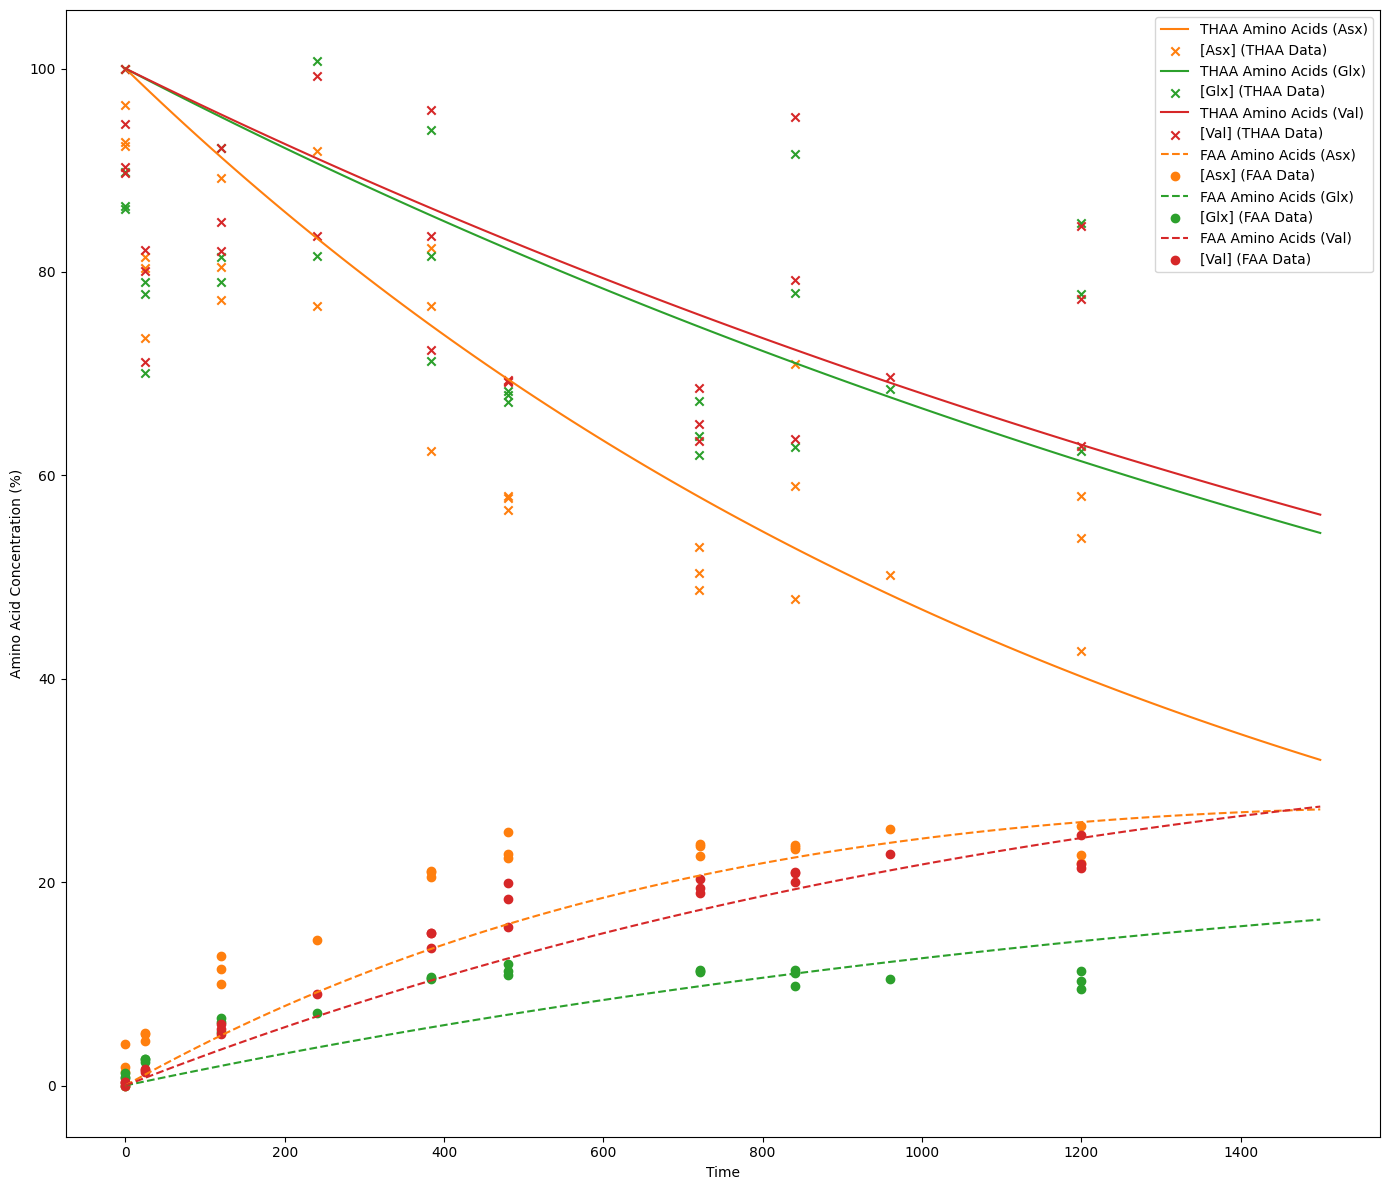

TypeError: 'NoneType' object is not callable

In [48]:
#@title ###Fitting decomposition and hydrolysis

# Define colors for plotting

colors = {
    # 'Asx': '#ff7f0e',
    # 'Glx': '#2ca02c',
    # 'Val': '#d62728',
    'I': '#ff7f0e',
    'P': '#2ca02c',
    'A': '#d62728',
    'Blanks': '#7d7d7d'  # Grey color for blanks
}


def simulate(timesteps, simulation_duration, k_hydrolysis, k_rac_internal_I, k_rac_terminal, k_rac_free, k_loss, closed_system=False, initial_water_to_protein_ratio=10):
    time = np.linspace(0, simulation_duration, timesteps)

    # Simulate hydrolysis and loss for each residue type
    hydrolysis_levels = {}
    total_levels = {}
    for residue in ['I', 'P', 'A']:
        free_conc_model, total_conc_model = hydrolysis_model(
            time, k_hydrolysis[residue], 1.0, k_loss[residue], closed_system, initial_water_to_protein_ratio
        )
        hydrolysis_levels[residue] = free_conc_model
        total_levels[residue] = total_conc_model

    # Simulate racemisation
    DL_chain, DL_terminal, DL_free = racemisation_model(time, k_rac_internal_I, k_rac_terminal, k_rac_free)

    return time, hydrolysis_levels, total_levels, DL_chain, DL_terminal, DL_free


# def simulate(timesteps, simulation_duration, k_hydrolysis, k_rac_internal_I, k_rac_terminal, k_rac_free, k_loss, closed_system=False, initial_water_to_protein_ratio=10):
#     time = np.linspace(0, simulation_duration, timesteps)

#     # Simulate hydrolysis and loss for each residue type
#     hydrolysis_levels_I, hydrolysis_levels_P, hydrolysis_levels_A = hydrolysis_model(
#         time, k_hydrolysis, 1.0, k_loss, closed_system, initial_water_to_protein_ratio
#     )

#     # Simulate racemisation
#     DL_I_chain, DL_terminal, DL_free = racemisation_model(time, k_rac_internal_I, k_rac_terminal, k_rac_free)

#     hydrolysis_levels_custom = {
#         'I': hydrolysis_levels_I,
#         'P': hydrolysis_levels_P,
#         'A': hydrolysis_levels_A
#     }

#     return time, hydrolysis_levels_custom, DL_I_chain, DL_terminal, DL_free

def fit_k_hydrolysis(time, free_conc, f_tot, initial_conc, k_loss, closed_system=False, initial_water_to_protein_ratio=10):
    def hydrolysis_model(t, k_hydrolysis):
        if closed_system:
            water_conc = initial_water_to_protein_ratio
            free_conc_model = np.zeros_like(t)
            for i in range(1, len(t)):
                delta_t = t[i] - t[i - 1]
                k_eff = pseudo_first_order_rate(f_tot, k_hydrolysis, water_conc)
                free_conc_model[i] = free_conc_model[i - 1] + (1 - np.exp(-k_eff * delta_t)) * np.exp(-k_loss * t[i])
                water_conc -= free_conc_model[i] / initial_water_to_protein_ratio
            return free_conc_model
        else:
            k_eff = pseudo_first_order_rate(f_tot, k_hydrolysis, initial_water_to_protein_ratio)
            return initial_conc * (1 - np.exp(-k_eff * t)) * np.exp(-k_loss * t)

    popt, _ = curve_fit(hydrolysis_model, time, free_conc, p0=[0.00002])
    return popt[0]

# Fit k_loss for I, A, and P based on the total concentration decline
time_total = df_total['time (h)']

# Fit k_loss for I, A, and P based on the total concentration decline
k_loss = {}
for residue in ['I', 'A', 'P']:
    k_loss[residue] = fit_k_loss(time_total_clean, total_clean[residue])
    print(f"Fitted k_loss for {residue}:", k_loss[residue])

# Fit k_hydrolysis for I, A, and P based on the free concentration increase
k_hydrolysis = {}
for residue in ['I', 'A', 'P']:
    k_hydrolysis[residue] = fit_k_hydrolysis(time_free_clean, free_clean[residue], f_I + f_P + f_A, 1, k_loss[residue], closed_system=True, initial_water_to_protein_ratio=10)
    print(f"Fitted k_hydrolysis for {residue}:", k_hydrolysis[residue])


# #Run the simulation with the fitted values
# time_custom, hydrolysis_levels_custom, DL_chain_custom, DL_terminal_custom, DL_free_custom = simulate(
#     timesteps, simulation_hours,
#     k_hydrolysis,
#     k_rac_internal_I,
#     k_rac_terminal,
#     k_rac_free,
#     k_loss,
#     closed_system=True,
#     initial_water_to_protein_ratio=initial_water_to_protein_ratio
# )

# Run the simulation with the fitted values
time_custom, hydrolysis_levels_custom, total_levels_custom, DL_chain_custom, DL_terminal_custom, DL_free_custom = simulate(
    timesteps, simulation_hours,
    k_hydrolysis=k_hydrolysis,  # Pass the entire dictionary
    k_rac_internal_I=k_rac_internal_I,
    k_rac_terminal=k_rac_terminal,
    k_rac_free=k_rac_free,
    k_loss=k_loss,  # Pass the entire dictionary
    closed_system=True,
    initial_water_to_protein_ratio=initial_water_to_protein_ratio
)
# # Run the simulation with the fitted values
# time_custom, hydrolysis_levels_custom, DL_chain_custom, DL_terminal_custom, DL_free_custom = simulate(
#     timesteps, simulation_hours,
#     k_hydrolysis['I'], k_hydrolysis['A'], k_hydrolysis['P'],
#     k_rac_internal_I, k_rac_terminal, k_rac_free,
#     k_loss['I'], k_loss['A'], k_loss['P'],
#     closed_system=True, initial_water_to_protein_ratio=initial_water_to_protein_ratio
# )

# Access the individual hydrolysis levels from the dictionary
hydrolysis_levels_I = hydrolysis_levels_custom['I']
hydrolysis_levels_P = hydrolysis_levels_custom['P']
hydrolysis_levels_A = hydrolysis_levels_custom['A']

# Plotting Functions
def plot_total_amino_acids(time, total_levels, label, color):
    plt.plot(time, total_levels * 100, label=label, color=color, linestyle='-')
    plt.xlabel('Time')
    plt.ylabel('Amino Acid Concentration (%)')
    plt.legend()

def plot_free_amino_acids(time, free_levels, label, color):
    plt.plot(time, free_levels * 100, label=label, color=color, linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Amino Acid Concentration (%)')
    plt.legend()

# Create the plot
fig, ax = plt.subplots(figsize=(14, 12))

# Plot THAA Amino Acid Concentration
for residue in ['I', 'P', 'A']:
    plot_total_amino_acids(time_custom, total_levels_custom[residue], f'THAA Amino Acids ({residue_to_amino_acid[residue]})', colors[residue])
    ax.scatter(df_total['time (h)'], df_total[conc_string_mapping[residue]] * 100, color=colors[residue], label=f'[{residue_to_amino_acid[residue]}] (THAA Data)', marker='x')

# Plot FAA Amino Acid Concentration
for residue in ['I', 'P', 'A']:
    plot_free_amino_acids(time_custom, hydrolysis_levels_custom[residue], f'FAA Amino Acids ({residue_to_amino_acid[residue]})', colors[residue])
    ax.scatter(df_free['time (h)'], df_free[conc_string_mapping[residue]] * 100, color=colors[residue], label=f'[{residue_to_amino_acid[residue]}] (FAA Data)', marker='o')

# Update legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()()
plt.show()

In [36]:
# Fit k_loss for I, A, and P based on the total concentration decline
k_loss_I = fit_k_loss(time_total_clean, df_total['[Asx]'])
print("Fitted k_loss for I:", k_loss_I)

k_loss_A = fit_k_loss(time_total_clean, df_total['[Val]'])
print("Fitted k_loss for A:", k_loss_A)

k_loss_P = fit_k_loss(time_total_clean, df_total['[Glx]'])
print("Fitted k_loss for P:", k_loss_P)

# Fit k_hydrolysis for I, A, and P based on the free concentration increase
k_hydrolysis_I = fit_k_hydrolysis(time_total_clean, df_free['[Asx]'], f_I + f_P + f_A, 1, k_loss_I, closed_system=True, initial_water_to_protein_ratio=10)
print("Fitted k_hydrolysis for I:", k_hydrolysis_I)

k_hydrolysis_A = fit_k_hydrolysis(time_total_clean, df_free['[Val]'], f_I + f_P + f_A, 1, k_loss_A, closed_system=True, initial_water_to_protein_ratio=10)
print("Fitted k_hydrolysis for A:", k_hydrolysis_A)

k_hydrolysis_P = fit_k_hydrolysis(time_total_clean, df_free['[Glx]'], f_I + f_P + f_A, 1, k_loss_P, closed_system=True, initial_water_to_protein_ratio=10)
print("Fitted k_hydrolysis for P:", k_hydrolysis_P)

Fitted k_loss for I: 0.0007591923145673186
Fitted k_loss for A: 0.0003849773521577074
Fitted k_loss for P: 0.0004066912330540304


ValueError: operands could not be broadcast together with shapes (28,) (27,) 

In [ ]:

def predict_racemization(params, time, k_hydrolysis, k_loss):
    k_rac_internal_I, k_rac_terminal, k_rac_free = params

    # Simulate the levels based on the racemization parameters
    _, hydrolysis_levels_I, hydrolysis_levels_P, hydrolysis_levels_A, DL_I_chain, DL_terminal, DL_free = simulate(len(time), max(time), k_hydrolysis, k_rac_internal_I, k_rac_terminal, k_rac_free, k_loss)

    return np.concatenate((DL_I_chain, DL_terminal, DL_free))




def fitting_racemization_function(time, k_rac_internal_I, k_rac_terminal, k_rac_free):
    return predict_racemization([k_rac_internal_I, k_rac_terminal, k_rac_free], time, k_hydrolysis, k_loss)

def plot_bound_amino_acids(time, bound_levels, label, color):
    plt.plot(time, bound_levels * 100, label=label, color=color)
    plt.xlabel('Time')
    plt.ylabel('Bound Amino Acid Concentration (%)')
    plt.legend()

In [ ]:
#@title #Fitting process logic:
# Initial guess for racemization parameters based on simplified model parameters
initial_guess_racemization = [k_rac_internal_I, k_rac_terminal, k_rac_free]

# Define bounds for the parameters to avoid numerical issues
param_bounds = ([1e-6, 1e-6, 1e-6], [1.0, 1.0, 1.0])

# Prepare the observed data for fitting (concatenate the DL ratios)
observed_DL_ratios_total = np.concatenate((df_total['Asx D/L'], df_total['Glx D/L'], df_total['Val D/L']))
observed_DL_ratios_free = np.concatenate((df_free['Asx D/L'], df_free['Glx D/L'], df_free['Val D/L']))

# Combine total and free observed data
observed_DL_ratios_combined = np.concatenate((observed_DL_ratios_total, observed_DL_ratios_free))

# Combine time data
time_combined = np.concatenate((df_total['time (h)'], df_free['time (h)']))

# Fit the racemization model to the observed data with bounds
print("Initial guess for racemization parameters:")
param_names_racemization = ["k_rac_internal_I", "k_rac_terminal", "k_rac_free"]
for name, value in zip(param_names_racemization, initial_guess_racemization):
    print(f"{name}: {value}")

# Fixed parameters
fixed_params = {
    'N': N,
    'f_I': f_I,
    'f_P': f_P,
    'f_A': f_A,
    'initial_water_to_protein_ratio': initial_water_to_protein_ratio,
    'timesteps': timesteps,
    'simulation_hours': simulation_hours,
    'k_hydrolysis': k_hydrolysis
}

print("\nFixed parameters used in the model:")
for name, value in fixed_params.items():
    print(f"{name}: {value}")

params_opt_racemization, params_cov_racemization = curve_fit(
    fitting_racemization_function,
    time_combined,
    observed_DL_ratios_combined,
    p0=initial_guess_racemization,
    bounds=param_bounds
)

print("\nFitted racemization parameters:")
for name, value in zip(param_names_racemization, params_opt_racemization):
    print(f"{name}: {value}")


In [ ]:
#@title ###Use original model parameters
# Define your own values for racemization rates
k_rac_internal_I_custom = 0.0045  # Custom racemization rate for I in the chain
k_rac_terminal_custom = 0.0006   # Custom unified racemization rate for I, P, and A at the end terminus
k_rac_free_custom = 0.000005       # Custom racemization rate for free amino acids
k_hydrolysis_custom_I = 0.00002  # Base hydrolysis rate
k_hydrolysis_custom_P = 0.00002  # Base hydrolysis rate
k_hydrolysis_custom_A = 0.00002  # Base hydrolysis rate
k_hydrolysis_I_factor = 10  # Custom rate of hydrolysis magnitude for I
k_loss_custom_I = 0.0006 # Custom rate of loss
k_loss_custom_A = 0.0006 # Custom rate of loss
k_loss_custom_P = 0.0006 # Custom rate of loss

In [ ]:
# Example fitting for Val
time_total = df_total['time (h)']
val_total_conc = df_total['[Val]']  # Normalized to 1
k_loss_val = fit_k_loss(time_total, val_total_conc)
print("Fitted k_loss for Val:", k_loss_val)

val_free_conc = df_free['[Val]']  # Normalized to 1
k_hydrolysis_val = fit_k_hydrolysis(time_total, val_free_conc, f_I + f_P + f_A, 1, k_loss_val)
print("Fitted k_hydrolysis for Val:", k_hydrolysis_val)

In [ ]:
#Glx special code
# Manually input k_loss and k_hydrolysis for Glx if needed
k_loss_glx = 0.01  # Example value
k_hydrolysis_glx = 0.001  # Example value

# Fit k_hydrolysis for Glx if not manually set
if not k_hydrolysis_glx:
    glx_free_conc = df_free['[Glx]']  # Normalized to 1
    k_hydrolysis_glx = fit_k_hydrolysis(time_total, glx_free_conc, f_I + f_P + f_A, 1, k_loss_glx)
    print("Fitted k_hydrolysis for Glx:", k_hydrolysis_glx)

In [ ]:
#@title ###Run the simulation with your own values

# Plotting the results of your custom simulation
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Plot FAA Amino Acid Concentration
axs[0, 0].plot(time_custom, hydrolysis_levels_I_custom * 100, label='FAA Amino Acids (I) - Custom', color=colors['I'])
axs[0, 0].plot(time_custom, hydrolysis_levels_P_custom * 100, label='FAA Amino Acids (P) - Custom', color=colors['P'])
axs[0, 0].plot(time_custom, hydrolysis_levels_A_custom * 100, label='FAA Amino Acids (A) - Custom', color=colors['A'])
axs[0, 0].scatter(df_free['time (h)'], df_free['[Asx]'] * 100, color=colors['I'], label='[I] (FAA Data)', marker='x')
axs[0, 0].scatter(df_free['time (h)'], df_free['[Glx]'] * 100, color=colors['P'], label='[P] (FAA Data)', marker='o')
axs[0, 0].scatter(df_free['time (h)'], df_free['[Val]'] * 100, color=colors['A'], label='[A] (FAA Data)', marker='s')
if len(df_blanks) > 0:
    axs[0, 0].scatter(df_blanks['time (h)'], df_blanks['[Asx]'] * 100, color=colors['Blanks'], label='[I] (Blanks)', marker='x')
    axs[0, 0].scatter(df_blanks['time (h)'], df_blanks['[Glx]'] * 100, color=colors['Blanks'], label='[P] (Blanks)', marker='o')
    axs[0, 0].scatter(df_blanks['time (h)'], df_blanks['[Val]'] * 100, color=colors['Blanks'], label='[A] (Blanks)', marker='s')
axs[0, 0].set_title('FAA Amino Acid Concentration')
axs[0, 0].legend()

# Plot FAA D/L ratios
axs[1, 0].plot(time_custom, DL_I_chain_custom, label='FAA D/L (I) - Custom', color=colors['I'])
axs[1, 0].plot(time_custom, DL_terminal_custom, label='FAA D/L (P) - Custom', color=colors['P'])
axs[1, 0].plot(time_custom, DL_free_custom, label='FAA D/L (A) - Custom', color=colors['A'])
axs[1, 0].scatter(df_free['time (h)'], df_free['Asx D/L'], color=colors['I'], label='Asx D/L (FAA Data)', marker='x')
axs[1, 0].scatter(df_free['time (h)'], df_free['Glx D/L'], color=colors['P'], label='Glx D/L (FAA Data)', marker='o')
axs[1, 0].scatter(df_free['time (h)'], df_free['Val D/L'], color=colors['A'], label='Val D/L (FAA Data)', marker='s')
if len(df_blanks) > 0:
    axs[1, 0].scatter(df_blanks['time (h)'], df_blanks['Asx D/L'], color=colors['Blanks'], label='Asx D/L (Blanks)', marker='x')
    axs[1, 0].scatter(df_blanks['time (h)'], df_blanks['Glx D/L'], color=colors['Blanks'], label='Glx D/L (Blanks)', marker='o')
    axs[1, 0].scatter(df_blanks['time (h)'], df_blanks['Val D/L'], color=colors['Blanks'], label='Val D/L (Blanks)', marker='s')
axs[1, 0].set_title('FAA D/L Ratios')
axs[1, 0].legend()

# Plot THAA D/L ratios
axs[1, 1].plot(time_custom, DL_I_chain_custom, label='THAA D/L (I) - Custom', color=colors['I'])
axs[1, 1].plot(time_custom, DL_terminal_custom, label='THAA D/L (P) - Custom', color=colors['P'])
axs[1, 1].plot(time_custom, DL_free_custom, label='THAA D/L (A) - Custom', color=colors['A'])
axs[1, 1].scatter(df_total['time (h)'], df_total['Asx D/L'], color=colors['I'], label='Asx D/L (THAA Data)', marker='x')
axs[1, 1].scatter(df_total['time (h)'], df_total['Glx D/L'], color=colors['P'], label='Glx D/L (THAA Data)', marker='o')
axs[1, 1].scatter(df_total['time (h)'], df_total['Val D/L'], color=colors['A'], label='Val D/L (THAA Data)', marker='s')
if len(df_blanks) > 0:
    axs[1, 1].scatter(df_blanks['time (h)'], df_blanks['Asx D/L'], color=colors['Blanks'], label='Asx D/L (Blanks)', marker='x')
    axs[1, 1].scatter(df_blanks['time (h)'], df_blanks['Glx D/L'], color=colors['Blanks'], label='Glx D/L (Blanks)', marker='o')
    axs[1, 1].scatter(df_blanks['time (h)'], df_blanks['Val D/L'], color=colors['Blanks'], label='Val D/L (Blanks)', marker='s')
axs[1, 1].set_title('THAA D/L Ratios')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
#@title ###Simulate with fitted racemization parameters
time, hydrolysis_levels_I, hydrolysis_levels_P, hydrolysis_levels_A, DL_I_chain, DL_terminal, DL_free = simulate(
    timesteps, simulation_hours,
    k_hydrolysis,
    params_opt_racemization[0],  # k_rac_internal_I
    params_opt_racemization[1],  # k_rac_terminal
    params_opt_racemization[2]   # k_rac_free
)

In [ ]:
#@title ###Plotting functions
plt.figure(figsize=(14, 12))

# Plot FAA D/L ratios
plt.subplot(2, 2, 1)
plot_DL_free(time, DL_I_chain, 'FAA D/L (I)', colors['I'])
plot_DL_free(time, DL_terminal, 'FAA D/L (P)', colors['P'])
plot_DL_free(time, DL_free, 'FAA D/L (A)', colors['A'])
plt.scatter(df_free['time (h)'], df_free['Asx D/L'], color=colors['Asx'], label='Asx D/L (FAA Data)', marker='x')
plt.scatter(df_free['time (h)'], df_free['Glx D/L'], color=colors['Glx'], label='Glx D/L (FAA Data)', marker='o')
plt.scatter(df_free['time (h)'], df_free['Val D/L'], color=colors['Val'], label='Val D/L (FAA Data)', marker='s')
plt.scatter(df_blanks['time (h)'], df_blanks['Asx D/L'], color=colors['Blanks'], label='Asx D/L (Blanks)', marker='x')
plt.scatter(df_blanks['time (h)'], df_blanks['Glx D/L'], color=colors['Blanks'], label='Glx D/L (Blanks)', marker='o')
plt.scatter(df_blanks['time (h)'], df_blanks['Val D/L'], color=colors['Blanks'], label='Val D/L (Blanks)', marker='s')
plt.legend()

# Plot THAA D/L ratios
plt.subplot(2, 2, 2)
plot_DL_total(time, DL_I_chain, 'THAA D/L (I)', colors['I'])
plot_DL_total(time, DL_terminal, 'THAA D/L (P)', colors['P'])
plot_DL_total(time, DL_free, 'THAA D/L (A)', colors['A'])
plt.scatter(df_total['time (h)'], df_total['Asx D/L'], color=colors['Asx'], label='Asx D/L (THAA Data)', marker='x')
plt.scatter(df_total['time (h)'], df_total['Glx D/L'], color=colors['Glx'], label='Glx D/L (THAA Data)', marker='o')
plt.scatter(df_total['time (h)'], df_total['Val D/L'], color=colors['Val'], label='Val D/L (THAA Data)', marker='s')
plt.scatter(df_blanks['time (h)'], df_blanks['Asx D/L'], color=colors['Blanks'], label='Asx D/L (Blanks)', marker='x')
plt.scatter(df_blanks['time (h)'], df_blanks['Glx D/L'], color=colors['Blanks'], label='Glx D/L (Blanks)', marker='o')
plt.scatter(df_blanks['time (h)'], df_blanks['Val D/L'], color=colors['Blanks'], label='Val D/L (Blanks)', marker='s')
plt.legend()

# Plot FAA Amino Acid Concentration
plt.subplot(2, 2, 3)
plot_free_amino_acids(time, hydrolysis_levels_I, 'FAA Amino Acids (Asx)', colors['Asx'])
plot_free_amino_acids(time, hydrolysis_levels_P, 'FAA Amino Acids (Glx)', colors['Glx'])
plot_free_amino_acids(time, hydrolysis_levels_A, 'FAA Amino Acids (Val)', colors['Val'])
plt.scatter(df_free['time (h)'], df_free['[Asx]'] * 100, color=colors['Asx'], label='[Asx] (FAA Data)', marker='x')
plt.scatter(df_free['time (h)'], df_free['[Glx]'] * 100, color=colors['Glx'], label='[Glx] (FAA Data)', marker='o')
plt.scatter(df_free['time (h)'], df_free['[Val]'] * 100, color=colors['Val'], label='[Val] (FAA Data)', marker='s')
plt.scatter(df_blanks['time (h)'], df_blanks['[Asx]'] * 100, color=colors['Blanks'], label='[Asx] (Blanks)', marker='x')
plt.scatter(df_blanks['time (h)'], df_blanks['[Glx]'] * 100, color=colors['Blanks'], label='[Glx] (Blanks)', marker='o')
plt.scatter(df_blanks['time (h)'], df_blanks['[Val]'] * 100, color=colors['Blanks'], label='[Val] (Blanks)', marker='s')
plt.legend()

# Plot Bound Amino Acid Concentration (THAA - FAA)
plt.subplot(2, 2, 4)
plot_bound_amino_acids(time, np.ones_like(time) - hydrolysis_levels_I, 'Bound Amino Acids (Asx)', colors['Asx'])
plot_bound_amino_acids(time, np.ones_like(time) - hydrolysis_levels_P, 'Bound Amino Acids (Glx)', colors['Glx'])
plot_bound_amino_acids(time, np.ones_like(time) - hydrolysis_levels_A, 'Bound Amino Acids (Val)', colors['Val'])
plt.scatter(df_total['time (h)'], (df_total['[Asx]'] - df_free['[Asx]']) * 100, color=colors['Asx'], label='Bound [Asx] (Data)', marker='x')
plt.scatter(df_total['time (h)'], (df_total['[Glx]'] - df_free['[Glx]']) * 100, color=colors['Glx'], label='Bound [Glx] (Data)', marker='o')
plt.scatter(df_total['time (h)'], (df_total['[Val]'] - df_free['[Val]']) * 100, color=colors['Val'], label='Bound [Val] (Data)', marker='s')
if len(df_blanks) > 0:
    plt.scatter([0], [df_blanks.iloc[0]['[Asx]'] * 100], color=colors['Blanks'], label='Bound [Asx] (Blanks)', marker='x')
    plt.scatter([0], [df_blanks.iloc[0]['[Glx]'] * 100], color=colors['Blanks'], label='Bound [Glx] (Blanks)', marker='o')
    plt.scatter([0], [df_blanks.iloc[0]['[Val]'] * 100], color=colors['Blanks'], label='Bound [Val] (Blanks)', marker='s')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_kobs(pH, pKa1, pKa2, k1, k2, k3, k4, k5, k6):
    # Calculate [H+] and [OH-]
    H = 10**(-pH)
    OH = 10**(-14 + pH)

    # Calculate alpha values (mole fractions of ionic species)
    denom = 1 + 10**(pKa1 - pH) + 10**(pH - pKa2)
    alpha_plus = 10**(pKa1 - pH) / denom
    alpha_zwitterion = 1 / denom
    alpha_minus = 10**(pH - pKa2) / denom

    # Calculate kobs
    kobs = (k1 * alpha_plus * H +
            k2 * alpha_plus * OH +
            k3 * alpha_zwitterion * H +
            k4 * alpha_zwitterion * OH +
            k5 * alpha_minus * H +
            k6 * alpha_minus * OH)

    return kobs

# Example values (you should replace these with actual values for your amino acid)
pKa1 = 2.34  # Example pKa for carboxyl group
pKa2 = 9.60  # Example pKa for amino group
k1, k2 = 9.72e-1, 1.90e3  # Example values for k1 and k2
k3, k4 = 7.50e-4, 2.22e-2  # Example values for k3 and k4
k5, k6 = 6.87e-7, 2.22e-5  # Example values for k5 and k6

# Generate pH range
pH_range = np.linspace(-1, 14, 1000)

# Calculate kobs for each pH
kobs_values = [calculate_kobs(pH, pKa1, pKa2, k1, k2, k3, k4, k5, k6) for pH in pH_range]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(pH_range, np.log10(kobs_values))
plt.xlabel('pH')
plt.ylabel('log kobs')
plt.title('Observed Racemization Rate Constant vs pH')
plt.grid(True)
plt.show()